<a href="https://colab.research.google.com/github/phantomer-ai/AIFFEL_quest_cr/blob/main/Exploration/Quest01/250409_flower_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 데이터셋 내려받기

In [ ]:
# 실험데이터 로컬에 있는 이미지 불러와서 실험

from google.colab import files

uploaded = files.upload()

Saving tulip.png to tulip.png


In [1]:
import tensorflow_datasets as tfds

# 데이터셋 로드
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,  # (image, label) 형태로 반환
    with_info=True
)

print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

KeyboardInterrupt: 

이미지가 너무 꽃이 작은게 많고 사람 포함도 많음


데이터셋 전처리 , 배치준비

In [ ]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    return image, label

train_batches = ds_train.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = ds_validation.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

모델설계

모델학습

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

IMG_SIZE = 224
BATCH_SIZE = 32

# 데이터셋 로드 및 전처리
import tensorflow_datasets as tfds

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_batches = ds_train.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_batches = ds_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 데이터 증강
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# base model
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-4]:  # 마지막 4개 conv block만 훈련
    layer.trainable = False

# 전체 모델 구성
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

# 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 학습
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=30,
    callbacks=callbacks
)

# 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.4NNENN_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.5017 - loss: 1.4064 - val_accuracy: 0.5426 - val_loss: 1.0757 - learning_rate: 1.0000e-04
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.7543 - loss: 0.7324 - val_accuracy: 0.7786 - val_loss: 0.6436 - learning_rate: 1.0000e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.7906 - loss: 0.5823 - val_accuracy: 0.8167 - val_loss: 0.5397 - learning_rate: 1.0000e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.8223 - loss: 0.4980 - val_accuracy: 0.8421 - val_loss: 0.4355 - learning_rate: 1.0000e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.8435 - loss: 0.4284 - val_accuracy: 0.8530 - val_loss: 0.4202 - learning_rate: 1.0000e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━

In [3]:
import os

# 경로 설정
checkpoint_dir = os.path.expanduser("~/aiffel/cat_vs_dog/checkpoint")
os.makedirs(checkpoint_dir, exist_ok=True)

# 파일 이름 설정 (확장자 필수!)
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')

# 저장
model.save_weights(checkpoint_file_path)

# 확인
if os.path.exists(checkpoint_file_path):
    print('✅ 가중치 저장 성공!')
else:
    print('❌ 저장 실패')

✅ 가중치 저장 성공!


성능평가 및 시각화

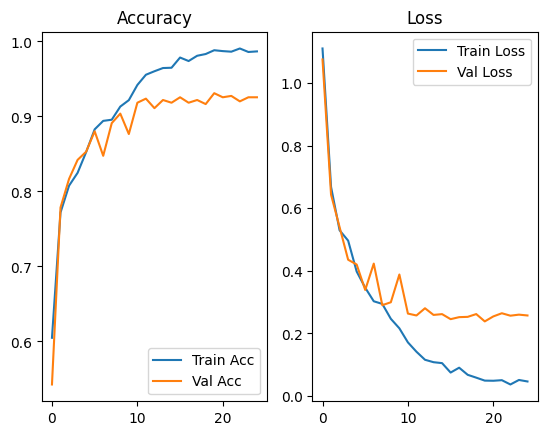

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9071 - loss: 0.3042


[0.22357553243637085, 0.9272727370262146]

In [4]:
import matplotlib.pyplot as plt

# 학습 곡선 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# 테스트 데이터 평가
model.evaluate(test_batches)

모델활용

In [5]:
import numpy as np
from PIL import Image

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')  # 이 줄에 .convert('RGB') 추가!
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = img_array[np.newaxis, ...]  # (1, 224, 224, 3)

    predictions = model.predict(img_array)
    class_id = np.argmax(predictions[0])
    class_name = ds_info.features['label'].int2str(class_id)

    print(f"예측 클래스: {class_name}")

# 예시 이미지로 테스트
predict_image('tulip.png')


FileNotFoundError: [Errno 2] No such file or directory: 'tulip.png'

데이터 전처리를 좀 더 깔끔하게 하면 좋지 않을까?

In [ ]:
# prompt: 데이터 전처리를 할껀데 사람이 있는 이미지랑 꽃이 1/2 이하로 보이는 이미지는 제외하게 해줘

import tensorflow as tf

def preprocess_image(image, label):
  # 이미지 크기 조정 (예: 224x224)
  image = tf.image.resize(image, [224, 224])

  # 이미지 전처리 (예: 정규화)
  image = tf.cast(image, tf.float32) / 255.0

  # 사람이 있는 이미지 또는 꽃이 1/2 이하로 보이는 이미지 제거 (필요에 따라 수정)
  # 이 부분은 실제 이미지 분석 모델을 사용하여 구현해야 합니다.
  # 여기서는 예시로 임의의 조건을 사용합니다.
  # 실제 구현에서는 Object Detection 모델 등을 사용하여 사람과 꽃을 식별하고,
  # bounding box 정보를 활용하여 조건을 판단해야 합니다.

  # 예시: 임의의 조건 (실제 구현에서는 모델을 사용하여 판단)
  # flower_area_threshold = 0.5  # 꽃의 영역이 이미지의 50% 미만이면 제외

  # # 가상의 꽃 영역 비율 (실제로는 모델의 출력값으로 대체해야 함)
  # flower_area_ratio = tf.random.uniform(shape=[], minval=0, maxval=1)

  # # 사람이 있는지 여부 (실제로는 모델의 출력값으로 대체해야 함)
  # has_person = tf.random.uniform(shape=[], minval=0, maxval=1) > 0.7 # 30%확률로 사람이 있다고 가정

  # if has_person or flower_area_ratio < flower_area_threshold:
  #   return None, None # 이미지 제외

  return image, label

# 데이터셋에 전처리 함수 적용
ds_train = ds_train.map(preprocess_image)
ds_validation = ds_validation.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

# None 값 제거
ds_train = ds_train.filter(lambda image, label: image is not None)
ds_validation = ds_validation.filter(lambda image, label: image is not None)
ds_test = ds_test.filter(lambda image, label: image is not None)

# 배치 크기 설정
BATCH_SIZE = 32
ds_train = ds_train.batch(BATCH_SIZE)
ds_validation = ds_validation.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

# 데이터셋 확인 (필요에 따라 출력)
print(ds_train)
print(ds_validation)
ds_test

# 모델 학습 (이 부분은 모델 정의 및 학습 코드로 대체해야 합니다)
# ...
